<div style="background-color: #424449; padding: 30px; text-align: center; font-size: 36px; font-weight: bold;">
  <span style="color: #caccd1;">1. Análise Exploratória</span>
</div>

In [1]:
# Configurações de visualização
%matplotlib inline
%config inlineBackend.figure_formats = ['svg']

# Importação das Bibliotecas
import pandas as pd
import numpy as np
import seaborn as sns
import statistics as sts
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX

from pandas_profiling import ProfileReport

from xgboost import XGBRegressor

from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.utils.plotting import plot_series
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.compose import make_reduction
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error as mapesktime
from sktime.forecasting.model_selection import ExpandingWindowSplitter
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError
from sktime.forecasting.model_selection import SlidingWindowSplitter
from sktime.forecasting.model_selection import ForecastingRandomizedSearchCV
from sktime.forecasting.compose import DirectTimeSeriesRegressionForecaster

from sklearn.preprocessing import MinMaxScaler
from pmdarima import auto_arima

import statsmodels.tsa.stattools as stattools
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss

from sklearn import metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error


from sklearn.model_selection import GridSearchCV


import warnings
warnings.filterwarnings('ignore')
# Configurações de visualização do dataset
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 90)

In [2]:
# Carregamento dos dados de treino em arquivo csv
df_raw = pd.read_csv('IPG2211A2N.csv')

In [3]:
# Colunas
df_raw.columns

Index(['DATE', 'IPG2211A2N'], dtype='object')

In [4]:
# Renomeação das colunas 
df_raw.columns = ['data', 'producao']

In [5]:
# Cópia do DataFrame raiz
df = df_raw.copy()

In [6]:
# Visualização do DataFrame
df.sample(5)

,data,producao
900,2014-01-01,122.1637
959,2018-12-01,110.5936
242,1959-03-01,19.2885
243,1959-04-01,18.8305
173,1953-06-01,11.8836


In [7]:
# EDA Automatizada
profile = ProfileReport(df, title='Relatório - Base de Dados', html={"styel":{'full_width':True}})
profile.to_notebook_iframe()
profile.to_file(output_file="Relatório - Base de Dados.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

O DataFrame apresenta 1008 linhas e 2 colunas, sendo que a coluna data precisa ser transformada para índice para termos uma série temporal.

O Dataframe também não possui valores nulos e nem valores duplicados.

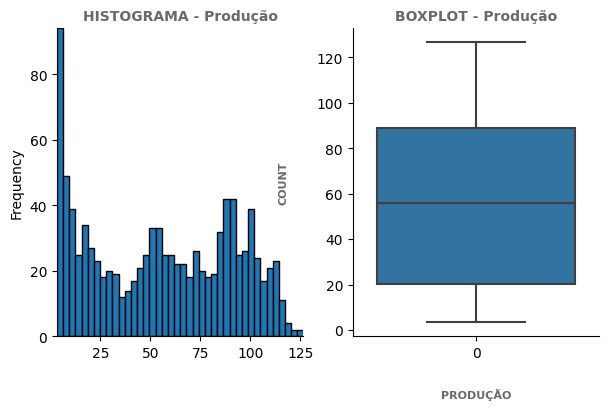

In [8]:
# Boxplot

plt.figure(figsize=(7,4))

#Plot
#plt.figure(figsize=(5,5))
plt.subplot(1, 2, 1)
df['producao'].plot.hist(bins=40, edgecolor='k').autoscale(enable=True, axis='both', tight=True)
sns.despine()
plt.title('HISTOGRAMA - Produção', fontsize = 10, color ='dimgrey', fontweight = 'bold')

plt.subplot(1, 2, 2)
sns.boxplot(df['producao'])
sns.despine()
plt.title('BOXPLOT - Produção', fontsize = 10, color ='dimgrey', fontweight = 'bold')
plt.xlabel('PRODUÇÃO', color = 'dimgrey', labelpad = 20, fontweight = 'bold', fontsize = 8)
plt.ylabel('COUNT', color = 'dimgrey', labelpad = 20, fontweight = 'bold', fontsize = 8);

plt.show();

De acordo com os gráficos acima não temos a presença de outliers no Dataframe.

In [9]:
# Transformar a coluna data em índice do Dataframe
df['data'] = pd.to_datetime(df['data'])
df = df.set_index("data")

In [10]:
# Data mínima e máxima do Dataframe
df.index.min(), df.index.max()

(Timestamp('1939-01-01 00:00:00'), Timestamp('2022-12-01 00:00:00'))

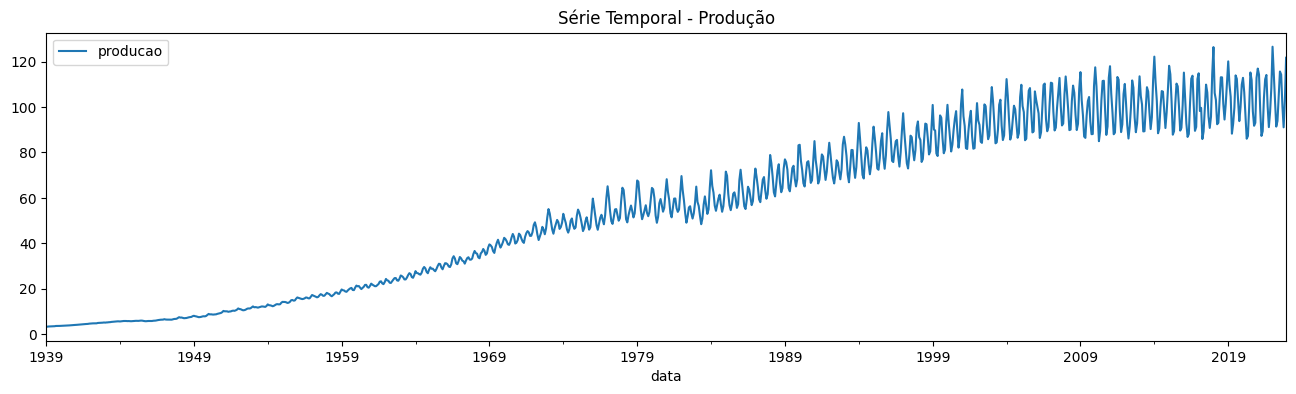

In [11]:
# Gráfico da série temporal
df.plot(figsize=(16,4),legend=True)

plt.title('Série Temporal - Produção')

plt.show();

<Figure size 800x600 with 0 Axes>

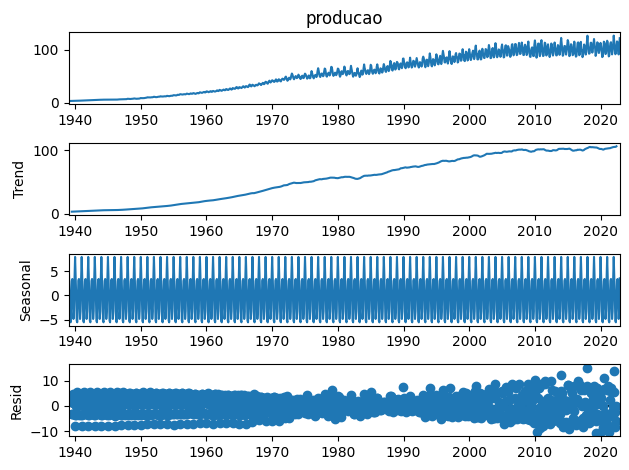

In [12]:
# Decomposição temporal
resultado = seasonal_decompose(df['producao'], period=12, model='duplicative')
fig = plt.figure(figsize=(8,6))
fig = resultado.plot()
plt.show();

A partir dos gráficos, percebemos uma tendência positiva e uma forte sazonalidade.

Para aplicar o modelo ARIMA (Autoregressive Integrated Moving Average) é necessário que a série temporal seja estacionária ou que possa ser transformada em uma série estacionária. A estacionariedade é importante porque o modelo ARIMA assume que a média, a variância e a estrutura de autocorrelação da série temporal são constantes ao longo do tempo. Se essas propriedades não forem satisfeitas, o modelo ARIMA pode produzir resultados imprecisos e enganosos.

Uma série temporal é considerada estacionária se suas propriedades estatísticas (média, variância e autocorrelação) não mudam ao longo do tempo. Isso significa que a série não apresenta tendências de longo prazo, sazonalidade ou outros padrões sistemáticos que possam afetar sua média ou variância ao longo do tempo.

Para identificar se uma série temporal é estacionária ou não, é necessário realizar testes estatísticos específicos, como o teste de Dickey-Fuller ou o teste KPSS. Esses testes avaliam se a média e a variância da série são constantes ao longo do tempo, ou seja, se a série é estacionária ou não.

**Teste ADF (Augmented Dickey-Fuller)**

O teste ADF (Augmented Dickey-Fuller) é um teste estatístico usado para determinar se uma série temporal é estacionária ou não. A hipótese nula (H0) e a hipótese alternativa (HA) do teste ADF são as seguintes:

**Hipótese nula (H0):** A série temporal possui uma raiz unitária, o que significa que não é estacionária.

**Hipótese alternativa (HA):** A série temporal não possui uma raiz unitária, o que significa que é estacionária.

Raiz unitária em série temporal é o conceito que indica a presença de uma tendência não estacionária na série, o que significa que a série não tem uma média constante ao longo do tempo.

O teste ADF verifica a presença de uma raiz unitária na série temporal e é um caso especial de um teste mais geral chamado teste de Dickey-Fuller. O teste ADF usa uma regressão linear para modelar a série temporal e testa a hipótese nula de que o coeficiente da primeira diferença da série é igual a zero.

Se o valor-p do teste ADF for menor que o nível de significância escolhido (geralmente 0,05), a hipótese nula de uma raiz unitária é rejeitada e a hipótese alternativa de que a série é estacionária é aceita. Se o valor-p for maior que o nível de significância, a hipótese nula não é rejeitada e a série é considerada não estacionária.

In [13]:
# Função para checar se a série temporal é estacionária pelo teste de Augmented Dickey-Fuller
def adfuller_test(df):
    result = adfuller(df)
    print('Teste ADF: p-valor =', result[1])
    
    if result[1] < 0.05:
        print('A série temporal é estacionária')
    else:
        print('A série temporal NÃO é estacionária')

In [14]:
# Teste Augmented Dickey-Fuller
adfuller_test(df['producao'])

Teste ADF: p-valor = 0.9253008031065345
A série temporal NÃO é estacionária


**Teste KPSS (Kwiatkowski-Phillips-Schmidt-Shin)**

O teste KPSS (Kwiatkowski-Phillips-Schmidt-Shin) é outro teste estatístico usado para determinar a estacionariedade de uma série temporal. A hipótese nula (H0) e a hipótese alternativa (HA) do teste KPSS são as seguintes:

**Hipótese nula (H0):** A série temporal é estacionária.

**Hipótese alternativa (HA):** A série temporal não é estacionária.

Diferentemente do teste ADF, o teste KPSS não assume que a série temporal possui uma raiz unitária. Em vez disso, o teste verifica se a série é estacionária em torno de uma tendência determinística, que pode ser uma constante ou uma função linear ou quadrática do tempo.

O teste KPSS usa uma regressão linear para modelar a série temporal e testa a hipótese nula de que a série é estacionária em torno da tendência determinística. Se o valor-p do teste KPSS for menor que o nível de significância escolhido (geralmente 0,05), a hipótese nula de estacionariedade é rejeitada e a hipótese alternativa de não estacionariedade é aceita. Se o valor-p for maior que o nível de significância, a hipótese nula não é rejeitada e a série é considerada estacionária em torno da tendência determinística.

Assim, o teste ADF testa se a série temporal possui uma raiz unitária, enquanto o teste KPSS testa se a série é estacionária em torno de uma tendência determinística. Ambos os testes são usados para verificar a estacionariedade de uma série temporal e podem ser usados em conjunto para obter uma conclusão mais robusta.

In [15]:
# Função para o teste KPSS 
def kpss_test(timeseries):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)
    
    if kpsstest[1] > 0.05:
        print('A série temporal é estacionária')
    else:
        print('A série temporal NÃO é estacionária')
        
#Referência: https://www.statsmodels.org/dev/examples/notebooks/generated/stationarity_detrending_adf_kpss.html

In [16]:
# Teste KPSS 
kpss_test(df['producao'])

Results of KPSS Test:
Test Statistic            5.157258
p-value                   0.010000
Lags Used                19.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64
A série temporal NÃO é estacionária


Ambos os testes confirmam que a série temporal de fato não é estacionária.